# Import + Define Section

In [ ]:
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np
import os
import cv2
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report

In [ ]:
import tensorflow as tf
import tensorflow_addons as tfa 

from tensorflow import keras 
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D 
from tensorflow.keras.layers import GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers.experimental import RandomFourierFeatures
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.metrics import Precision, Recall

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [ ]:
dataset_path = "/content/drive/My Drive/Colab Notebooks/Thai Dessert Dataset Augmented/Train"
dataset_test_path = "/content/drive/My Drive/Colab Notebooks/Thai Dessert Dataset Augmented/Test"
saved_path = "/content/drive/My Drive/Colab Notebooks/Thai Dessert Saved Models/"

## Function Define

In [ ]:
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

In [ ]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# Transfer InceptionV3

In [ ]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000
img_height = 160
img_width = 160

train_batches = tf.keras.preprocessing.image_dataset_from_directory(
  dataset_path,
  validation_split=0.2,
  subset="training",
  seed=123,
  shuffle = True,
  image_size=(img_height, img_width),
  batch_size=BATCH_SIZE,
  label_mode='categorical')

Found 8256 files belonging to 10 classes.
Using 6605 files for training.


In [ ]:
validation_batches = tf.keras.preprocessing.image_dataset_from_directory(
  dataset_path,
  validation_split=0.2,
  subset="validation",
  seed=123,
  shuffle = True,
  image_size=(img_height, img_width),
  batch_size=BATCH_SIZE,
  label_mode='categorical')

Found 8256 files belonging to 10 classes.
Using 1651 files for validation.


In [ ]:
class_names = train_batches.class_names
print(class_names)
print(train_batches)
print(validation_batches)

['kanom_bua_loi', 'kanom_chan', 'kanom_dok_jok', 'kanom_kai_tao', 'kanom_krok', 'kanom_phoi_tong', 'kanom_salim', 'kanom_sangkhaya_faktong', 'kanom_tong_yib', 'kanom_tong_yod']
<BatchDataset shapes: ((None, 160, 160, 3), (None, 10)), types: (tf.float32, tf.float32)>
<BatchDataset shapes: ((None, 160, 160, 3), (None, 10)), types: (tf.float32, tf.float32)>


In [ ]:
IMG_SHAPE = (160, 160, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.InceptionV3(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet',
                                               classifier_activation="softmax")
base_model.trainable = False

# Let's take a look at the base model architecture
base_model.summary()

87916544/87910968 [==============================] - 1s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 79, 79, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 79, 79, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 79, 79, 32)   0           batch_normalization[0][0]        
______________________

In [ ]:
global_average_layer = GlobalAveragePooling2D()
preds = Dense(10,activation='softmax')#final layer with softmax activation for N classes

In [ ]:
model = Sequential([
  base_model,
  global_average_layer,
  preds
])

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy',f1_m,precision_m, recall_m]) 

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 3, 3, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                20490     
Total params: 21,823,274
Trainable params: 20,490
Non-trainable params: 21,802,784
_________________________________________________________________


In [ ]:
initial_epochs = 50
validation_steps = 20

loss, accuracy, f1_score, precision, recall  = model.evaluate(validation_batches, steps = validation_steps)

20/20 [==============================] - 2s 110ms/step - loss: 63.0077 - accuracy: 0.1344 - f1_m: 0.1329 - precision_m: 0.1330 - recall_m: 0.1328


In [ ]:
history = model.fit(train_batches,
                    epochs=initial_epochs,
                    validation_data=validation_batches
                    )

Epoch 1/50
207/207 [==============================] - 29s 141ms/step - loss: 17.9675 - accuracy: 0.1671 - f1_m: 0.1659 - precision_m: 0.1673 - recall_m: 0.1646 - val_loss: 13.6215 - val_accuracy: 0.2084 - val_f1_m: 0.2043 - val_precision_m: 0.2074 - val_recall_m: 0.2014
Epoch 2/50
207/207 [==============================] - 29s 139ms/step - loss: 12.2843 - accuracy: 0.2039 - f1_m: 0.2036 - precision_m: 0.2065 - recall_m: 0.2009 - val_loss: 11.2009 - val_accuracy: 0.2193 - val_f1_m: 0.2191 - val_precision_m: 0.2221 - val_recall_m: 0.2162
Epoch 3/50
207/207 [==============================] - 28s 135ms/step - loss: 10.4238 - accuracy: 0.2254 - f1_m: 0.2238 - precision_m: 0.2276 - recall_m: 0.2202 - val_loss: 10.7157 - val_accuracy: 0.2223 - val_f1_m: 0.2225 - val_precision_m: 0.2263 - val_recall_m: 0.2190
Epoch 4/50
207/207 [==============================] - 28s 135ms/step - loss: 9.2957 - accuracy: 0.2359 - f1_m: 0.2335 - precision_m: 0.2381 - recall_m: 0.2292 - val_loss: 9.3172 - val_acc

In [ ]:
model_file_name = 'model_inceptionv3_not_tuning_v1'
print(saved_path+model_file_name+'.h5')
model.save(saved_path+model_file_name+'.h5')

/content/drive/My Drive/Colab Notebooks/Thai Dessert Saved Models/model_inceptionv3_not_tuning_v1.h5


### Fine Tuning

In [ ]:
base_model.trainable = True
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  311


In [ ]:
fine_tune_at = 306

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy',f1_m,precision_m, recall_m])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 3, 3, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                20490     
Total params: 21,823,274
Trainable params: 20,490
Non-trainable params: 21,802,784
_________________________________________________________________


In [ ]:
fine_tune_epochs = 30
total_epochs =  initial_epochs + fine_tune_epochs

filepath = saved_path+"model_inceptionv3_tuned_v1.h5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

history_fine = model.fit(train_batches,
                         epochs=total_epochs,
                         initial_epoch =  history.epoch[-1],
                         validation_data=validation_batches,
                         callbacks=callbacks_list)

Epoch 50/80
207/207 [==============================] - ETA: 0s - loss: 2.0709 - accuracy: 0.5344 - f1_m: 0.5316 - precision_m: 0.5697 - recall_m: 0.4995
Epoch 00050: loss improved from inf to 2.07085, saving model to /content/drive/My Drive/Colab Notebooks/Thai Dessert Saved Models/model_inceptionv3_v1.h5
207/207 [==============================] - 31s 148ms/step - loss: 2.0709 - accuracy: 0.5344 - f1_m: 0.5316 - precision_m: 0.5697 - recall_m: 0.4995 - val_loss: 4.0311 - val_accuracy: 0.3846 - val_f1_m: 0.3780 - val_precision_m: 0.3982 - val_recall_m: 0.3605
Epoch 51/80
206/207 [============================>.] - ETA: 0s - loss: 2.0081 - accuracy: 0.5420 - f1_m: 0.5409 - precision_m: 0.5821 - recall_m: 0.5061
Epoch 00051: loss improved from 2.07085 to 2.00578, saving model to /content/drive/My Drive/Colab Notebooks/Thai Dessert Saved Models/model_inceptionv3_v1.h5
207/207 [==============================] - 29s 139ms/step - loss: 2.0058 - accuracy: 0.5423 - f1_m: 0.5417 - precision_m: 0.

In [ ]:
test_generator = ImageDataGenerator()
test_data_generator = test_generator.flow_from_directory(
    dataset_test_path,
    target_size=(160, 160),
    batch_size=32,
    shuffle=False)
test_steps_per_epoch = np.math.ceil(test_data_generator.samples / test_data_generator.batch_size)

predictions = model.predict_generator(test_data_generator, steps=test_steps_per_epoch)
# Get most likely class
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_data_generator.classes
class_labels = list(test_data_generator.class_indices.keys())  

report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report) 

Found 500 images belonging to 10 classes.
                         precision    recall  f1-score   support

          kanom_bua_loi       0.46      0.44      0.45        50
             kanom_chan       0.40      0.40      0.40        50
          kanom_dok_jok       0.43      0.48      0.45        50
          kanom_kai_tao       0.33      0.34      0.34        50
             kanom_krok       0.36      0.46      0.40        50
        kanom_phoi_tong       0.38      0.40      0.39        50
            kanom_salim       0.43      0.40      0.41        50
kanom_sangkhaya_faktong       0.17      0.16      0.16        50
         kanom_tong_yib       0.39      0.32      0.35        50
         kanom_tong_yod       0.34      0.30      0.32        50

               accuracy                           0.37       500
              macro avg       0.37      0.37      0.37       500
           weighted avg       0.37      0.37      0.37       500



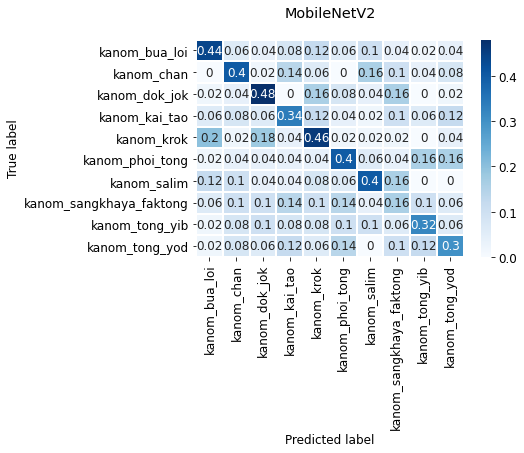

In [ ]:
cf_matrix = confusion_matrix(true_classes, predicted_classes, normalize='true')
sns.heatmap(cf_matrix, annot=True, cmap='Blues', linewidths=1,xticklabels=class_names,yticklabels=class_names)

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('MobileNetV2\n')
plt.show()

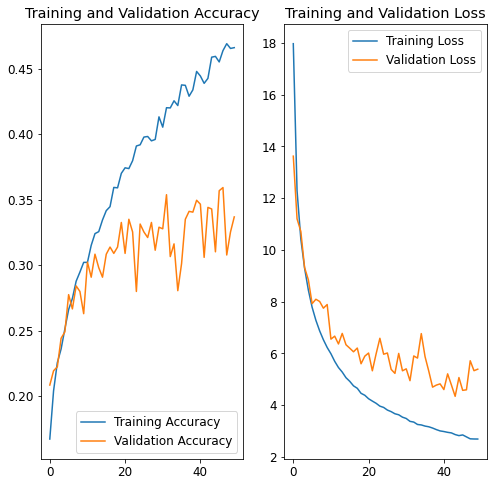

In [ ]:
# Visualize training results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(50)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Transfer MoblieNet V2



In [ ]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000
img_height = 160
img_width = 160

train_batches = tf.keras.preprocessing.image_dataset_from_directory(
  dataset_path,
  validation_split=0.2,
  subset="training",
  seed=123,
  shuffle = True,
  image_size=(img_height, img_width),
  batch_size=BATCH_SIZE,
  label_mode='categorical')

Found 8256 files belonging to 10 classes.
Using 6605 files for training.


In [ ]:
validation_batches = tf.keras.preprocessing.image_dataset_from_directory(
  dataset_path,
  validation_split=0.2,
  subset="validation",
  seed=123,
  shuffle = True,
  image_size=(img_height, img_width),
  batch_size=BATCH_SIZE,
  label_mode='categorical')

Found 8256 files belonging to 10 classes.
Using 1651 files for validation.


In [ ]:
class_names = train_batches.class_names
print(class_names)
# print(test_batches.class_names)
print(train_batches)
print(validation_batches)

['kanom_bua_loi', 'kanom_chan', 'kanom_dok_jok', 'kanom_kai_tao', 'kanom_krok', 'kanom_phoi_tong', 'kanom_salim', 'kanom_sangkhaya_faktong', 'kanom_tong_yib', 'kanom_tong_yod']
['kanom_bua_loi', 'kanom_chan', 'kanom_dok_jok', 'kanom_kai_tao', 'kanom_krok', 'kanom_phoi_tong', 'kanom_salim', 'kanom_sangkhaya_faktong', 'kanom_tong_yib', 'kanom_tong_yod']
<BatchDataset shapes: ((None, 160, 160, 3), (None, 10)), types: (tf.float32, tf.float32)>
<BatchDataset shapes: ((None, 160, 160, 3), (None, 10)), types: (tf.float32, tf.float32)>


In [ ]:
IMG_SHAPE = (160, 160, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False

9412608/9406464 [==============================] - 0s 0us/step


In [ ]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 161, 161, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

In [ ]:
global_average_layer = GlobalAveragePooling2D()
preds = Dense(10,activation='softmax')#final layer with softmax activation for N classes

In [ ]:
model = Sequential([
  base_model,
  global_average_layer,
  preds
])

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy',f1_m,precision_m, recall_m]) 

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                12810     
Total params: 2,270,794
Trainable params: 12,810
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
initial_epochs = 50
validation_steps = 20

loss, accuracy, f1_score, precision, recall  = model.evaluate(validation_batches, steps = validation_steps)

20/20 [==============================] - 273s 14s/step - loss: 2.9440 - accuracy: 0.0625 - f1_m: 0.0107 - precision_m: 0.0367 - recall_m: 0.0063


In [ ]:
history = model.fit(train_batches,
                    epochs=initial_epochs,
                    validation_data=validation_batches
                    )

Epoch 1/50
207/207 [==============================] - 2484s 12s/step - loss: 2.2436 - accuracy: 0.2005 - f1_m: 0.0185 - precision_m: 0.1989 - recall_m: 0.0098 - val_loss: 1.9128 - val_accuracy: 0.3465 - val_f1_m: 0.0530 - val_precision_m: 0.5272 - val_recall_m: 0.0282
Epoch 2/50
207/207 [==============================] - 23s 111ms/step - loss: 1.7465 - accuracy: 0.4050 - f1_m: 0.1488 - precision_m: 0.7521 - recall_m: 0.0855 - val_loss: 1.5999 - val_accuracy: 0.4615 - val_f1_m: 0.2203 - val_precision_m: 0.8286 - val_recall_m: 0.1300
Epoch 3/50
207/207 [==============================] - 23s 110ms/step - loss: 1.5190 - accuracy: 0.4924 - f1_m: 0.2849 - precision_m: 0.8193 - recall_m: 0.1764 - val_loss: 1.4442 - val_accuracy: 0.5094 - val_f1_m: 0.3289 - val_precision_m: 0.8147 - val_recall_m: 0.2104
Epoch 4/50
207/207 [==============================] - 23s 110ms/step - loss: 1.3914 - accuracy: 0.5375 - f1_m: 0.3710 - precision_m: 0.8127 - recall_m: 0.2451 - val_loss: 1.3488 - val_accuracy:

In [ ]:
model_file_name = 'model_mobilenetv2_not_tuning_v1'
print(saved_path+model_file_name+'.h5')
model.save(saved_path+model_file_name+'.h5')

/content/drive/My Drive/Colab Notebooks/Thai Dessert Saved Models/model_mobilenetv2_not_tuning_v1.h5


### Fine Tuning

In [ ]:
base_model.trainable = True
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  155


In [ ]:
fine_tune_at = 152

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy',f1_m,precision_m, recall_m])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                12810     
Total params: 2,270,794
Trainable params: 424,970
Non-trainable params: 1,845,824
_________________________________________________________________


In [ ]:
fine_tune_epochs = 20
total_epochs =  initial_epochs + fine_tune_epochs

filepath = saved_path+"model_moblienet_tuned_v1.h5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

history_fine = model.fit(train_batches,
                         epochs=total_epochs,
                         initial_epoch =  history.epoch[-1],
                         validation_data=validation_batches,
                         callbacks=callbacks_list)

Epoch 50/70
207/207 [==============================] - ETA: 0s - loss: 1.0166 - accuracy: 0.6701 - f1_m: 0.6640 - precision_m: 0.7380 - recall_m: 0.6054
Epoch 00050: loss improved from inf to 1.01661, saving model to /content/drive/My Drive/Colab Notebooks/Thai Dessert Saved Models/model_moblienet_tuned_v1.h5
207/207 [==============================] - 25s 121ms/step - loss: 1.0166 - accuracy: 0.6701 - f1_m: 0.6640 - precision_m: 0.7380 - recall_m: 0.6054 - val_loss: 1.0823 - val_accuracy: 0.6275 - val_f1_m: 0.6120 - val_precision_m: 0.7309 - val_recall_m: 0.5292
Epoch 51/70
205/207 [============================>.] - ETA: 0s - loss: 0.8172 - accuracy: 0.7290 - f1_m: 0.7243 - precision_m: 0.8100 - recall_m: 0.6573
Epoch 00051: loss improved from 1.01661 to 0.81523, saving model to /content/drive/My Drive/Colab Notebooks/Thai Dessert Saved Models/model_moblienet_tuned_v1.h5
207/207 [==============================] - 25s 119ms/step - loss: 0.8152 - accuracy: 0.7294 - f1_m: 0.7254 - precisi

In [ ]:
test_generator = ImageDataGenerator()
test_data_generator = test_generator.flow_from_directory(
    dataset_test_path,
    target_size=(160, 160),
    batch_size=32,
    shuffle=False)
test_steps_per_epoch = np.math.ceil(test_data_generator.samples / test_data_generator.batch_size)

predictions = model.predict_generator(test_data_generator, steps=test_steps_per_epoch)
# Get most likely class
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_data_generator.classes
class_labels = list(test_data_generator.class_indices.keys())  

report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report) 

Found 500 images belonging to 10 classes.
                         precision    recall  f1-score   support

          kanom_bua_loi       0.77      0.82      0.80        50
             kanom_chan       0.73      0.72      0.73        50
          kanom_dok_jok       0.89      0.62      0.73        50
          kanom_kai_tao       0.77      0.60      0.67        50
             kanom_krok       0.66      0.66      0.66        50
        kanom_phoi_tong       0.51      0.86      0.64        50
            kanom_salim       0.61      0.76      0.68        50
kanom_sangkhaya_faktong       0.70      0.56      0.62        50
         kanom_tong_yib       0.53      0.46      0.49        50
         kanom_tong_yod       0.70      0.62      0.66        50

               accuracy                           0.67       500
              macro avg       0.69      0.67      0.67       500
           weighted avg       0.69      0.67      0.67       500



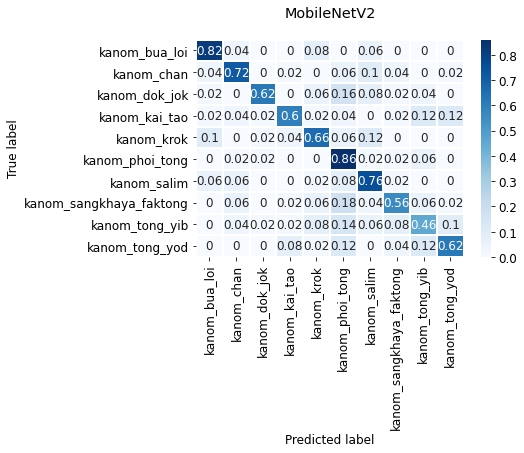

In [ ]:
cf_matrix = confusion_matrix(true_classes, predicted_classes, normalize='true')
sns.heatmap(cf_matrix, annot=True, cmap='Blues', linewidths=1,xticklabels=class_names,yticklabels=class_names)

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('InceptionV3\n')
plt.show()

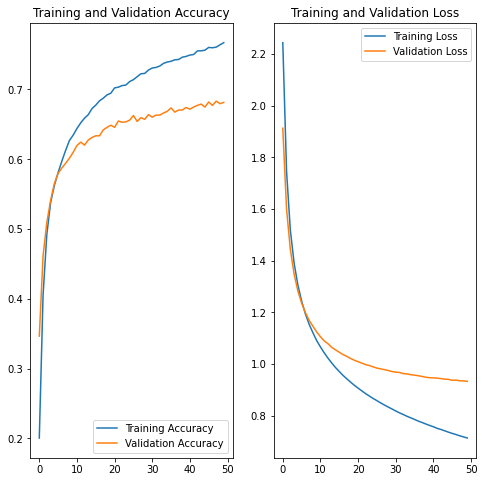

In [ ]:
# Visualize training results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(50)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Transfer Xeception

In [ ]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000
img_height = 160
img_width = 160

train_batches = tf.keras.preprocessing.image_dataset_from_directory(
  dataset_path,
  validation_split=0.2,
  subset="training",
  seed=123,
  shuffle = True,
  image_size=(img_height, img_width),
  batch_size=BATCH_SIZE,
  label_mode='categorical')

Found 8256 files belonging to 10 classes.
Using 6605 files for training.


In [ ]:
validation_batches = tf.keras.preprocessing.image_dataset_from_directory(
  dataset_path,
  validation_split=0.2,
  subset="validation",
  seed=123,
  shuffle = True,
  image_size=(img_height, img_width),
  batch_size=BATCH_SIZE,
  label_mode='categorical')

Found 8256 files belonging to 10 classes.
Using 1651 files for validation.


In [ ]:
class_names = train_batches.class_names
print(class_names)
print(train_batches)
print(validation_batches)

['kanom_bua_loi', 'kanom_chan', 'kanom_dok_jok', 'kanom_kai_tao', 'kanom_krok', 'kanom_phoi_tong', 'kanom_salim', 'kanom_sangkhaya_faktong', 'kanom_tong_yib', 'kanom_tong_yod']
<BatchDataset shapes: ((None, 160, 160, 3), (None, 10)), types: (tf.float32, tf.float32)>
<BatchDataset shapes: ((None, 160, 160, 3), (None, 10)), types: (tf.float32, tf.float32)>


In [ ]:
IMG_SHAPE = (160, 160, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.Xception(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet',
                                               classifier_activation="softmax")
base_model.trainable = False

# Let's take a look at the base model architecture
base_model.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 79, 79, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 79, 79, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 79, 79, 32)   0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [ ]:
global_average_layer = GlobalAveragePooling2D()
preds = Dense(10,activation='softmax')#final layer with softmax activation for N classes

In [ ]:
modelXecption = Sequential([
  base_model,
  global_average_layer,
  preds
])

In [ ]:
base_learning_rate = 0.0001
modelXecption.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy',f1_m,precision_m, recall_m]) 

In [ ]:
modelXecption.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 5, 5, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                20490     
Total params: 20,881,970
Trainable params: 20,490
Non-trainable params: 20,861,480
_________________________________________________________________


In [ ]:
initial_epochs = 50
validation_steps = 20

loss, accuracy, f1_score, precision, recall  = modelXecption.evaluate(validation_batches, steps = validation_steps)

20/20 [==============================] - 3s 127ms/step - loss: 24.7728 - accuracy: 0.1094 - f1_m: 0.1072 - precision_m: 0.1082 - recall_m: 0.1063


In [ ]:
history = modelXecption.fit(train_batches,
                    epochs=initial_epochs,
                    validation_data=validation_batches
                    )

Epoch 1/50
207/207 [==============================] - 32s 153ms/step - loss: 5.2402 - accuracy: 0.2666 - f1_m: 0.2593 - precision_m: 0.2757 - recall_m: 0.2451 - val_loss: 4.7556 - val_accuracy: 0.2804 - val_f1_m: 0.2742 - val_precision_m: 0.2946 - val_recall_m: 0.2569
Epoch 2/50
207/207 [==============================] - 31s 152ms/step - loss: 4.2797 - accuracy: 0.3122 - f1_m: 0.3038 - precision_m: 0.3264 - recall_m: 0.2848 - val_loss: 4.0949 - val_accuracy: 0.3277 - val_f1_m: 0.3205 - val_precision_m: 0.3476 - val_recall_m: 0.2979
Epoch 3/50
207/207 [==============================] - 31s 150ms/step - loss: 3.7625 - accuracy: 0.3408 - f1_m: 0.3298 - precision_m: 0.3562 - recall_m: 0.3078 - val_loss: 3.8588 - val_accuracy: 0.3343 - val_f1_m: 0.3254 - val_precision_m: 0.3516 - val_recall_m: 0.3035
Epoch 4/50
207/207 [==============================] - 31s 150ms/step - loss: 3.4092 - accuracy: 0.3656 - f1_m: 0.3598 - precision_m: 0.3897 - recall_m: 0.3350 - val_loss: 3.4128 - val_accuracy:

In [ ]:
model_file_name = 'model_xception_not_tuning_v3'
print(saved_path+model_file_name+'.h5')
modelXecption.save(saved_path+model_file_name+'.h5')

/content/drive/My Drive/Colab Notebooks/Thai Dessert Saved Models/model_xception_not_tuning_v3.h5


In [ ]:
test_generator = ImageDataGenerator()
test_data_generator = test_generator.flow_from_directory(
    dataset_test_path,
    target_size=(160, 160),
    batch_size=32,
    shuffle=False)
test_steps_per_epoch = np.math.ceil(test_data_generator.samples / test_data_generator.batch_size)

predictions = modelXecption.predict_generator(test_data_generator, steps=test_steps_per_epoch)
# Get most likely class
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_data_generator.classes
class_labels = list(test_data_generator.class_indices.keys())  

report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report) 

Found 500 images belonging to 10 classes.
                         precision    recall  f1-score   support

          kanom_bua_loi       0.57      0.72      0.64        50
             kanom_chan       0.46      0.70      0.56        50
          kanom_dok_jok       0.55      0.74      0.63        50
          kanom_kai_tao       0.55      0.46      0.50        50
             kanom_krok       0.60      0.58      0.59        50
        kanom_phoi_tong       0.46      0.60      0.52        50
            kanom_salim       0.64      0.36      0.46        50
kanom_sangkhaya_faktong       0.46      0.46      0.46        50
         kanom_tong_yib       0.62      0.30      0.41        50
         kanom_tong_yod       0.57      0.42      0.48        50

               accuracy                           0.53       500
              macro avg       0.55      0.53      0.52       500
           weighted avg       0.55      0.53      0.52       500



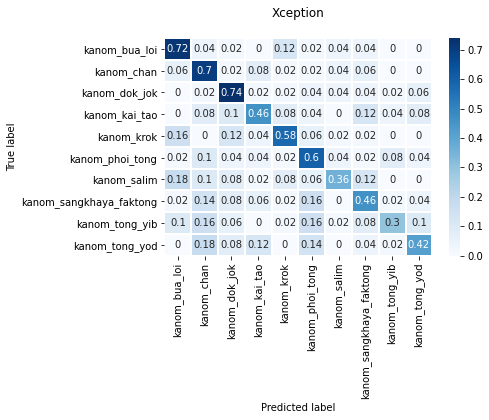

In [ ]:
cf_matrix = confusion_matrix(true_classes, predicted_classes, normalize='true')
sns.heatmap(cf_matrix, annot=True, cmap='Blues', linewidths=1,xticklabels=class_names,yticklabels=class_names)

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Xception\n')
plt.show()

### Fine Tuning


In [ ]:
base_model.trainable = True
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  132


In [ ]:
fine_tune_at = 129

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

In [ ]:
modelXecption.compile(loss='categorical_crossentropy',
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy',f1_m,precision_m, recall_m])

modelXecption.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 5, 5, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                20490     
Total params: 20,881,970
Trainable params: 24,586
Non-trainable params: 20,857,384
_________________________________________________________________


In [ ]:
fine_tune_epochs = 30
total_epochs =  initial_epochs + fine_tune_epochs

filepath = saved_path+"model_xception_tuned_v3.h5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

history_fine = modelXecption.fit(train_batches,
                         epochs=total_epochs,
                         initial_epoch =  history.epoch[-1],
                         validation_data=validation_batches,
                         callbacks=callbacks_list)

Epoch 50/80
206/207 [============================>.] - ETA: 0s - loss: 2.0973 - accuracy: 0.2990 - f1_m: 0.0157 - precision_m: 0.2168 - recall_m: 0.0082
Epoch 00050: loss improved from inf to 2.09790, saving model to /content/drive/My Drive/Colab Notebooks/Thai Dessert Saved Models/model_xception_tuned_v3.h5
207/207 [==============================] - 33s 159ms/step - loss: 2.0979 - accuracy: 0.2989 - f1_m: 0.0156 - precision_m: 0.2158 - recall_m: 0.0082 - val_loss: 2.0614 - val_accuracy: 0.3646 - val_f1_m: 0.0023 - val_precision_m: 0.0385 - val_recall_m: 0.0012
Epoch 51/80
206/207 [============================>.] - ETA: 0s - loss: 2.0338 - accuracy: 0.3504 - f1_m: 0.0062 - precision_m: 0.0971 - recall_m: 0.0032
Epoch 00051: loss improved from 2.09790 to 2.03368, saving model to /content/drive/My Drive/Colab Notebooks/Thai Dessert Saved Models/model_xception_tuned_v3.h5
207/207 [==============================] - 34s 164ms/step - loss: 2.0337 - accuracy: 0.3506 - f1_m: 0.0061 - precision

In [ ]:
test_generator = ImageDataGenerator()
test_data_generator = test_generator.flow_from_directory(
    dataset_test_path,
    target_size=(160, 160),
    batch_size=32,
    shuffle=False)
test_steps_per_epoch = np.math.ceil(test_data_generator.samples / test_data_generator.batch_size)

predictions = modelXecption.predict_generator(test_data_generator, steps=test_steps_per_epoch)
# Get most likely class
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_data_generator.classes
class_labels = list(test_data_generator.class_indices.keys())  

report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report) 

Found 500 images belonging to 10 classes.
                         precision    recall  f1-score   support

          kanom_bua_loi       0.44      0.78      0.56        50
             kanom_chan       0.48      0.28      0.35        50
          kanom_dok_jok       0.45      0.56      0.50        50
          kanom_kai_tao       0.34      0.54      0.42        50
             kanom_krok       0.56      0.48      0.52        50
        kanom_phoi_tong       0.37      0.52      0.43        50
            kanom_salim       0.50      0.28      0.36        50
kanom_sangkhaya_faktong       0.34      0.26      0.30        50
         kanom_tong_yib       0.36      0.08      0.13        50
         kanom_tong_yod       0.39      0.38      0.38        50

               accuracy                           0.42       500
              macro avg       0.42      0.42      0.39       500
           weighted avg       0.42      0.42      0.39       500



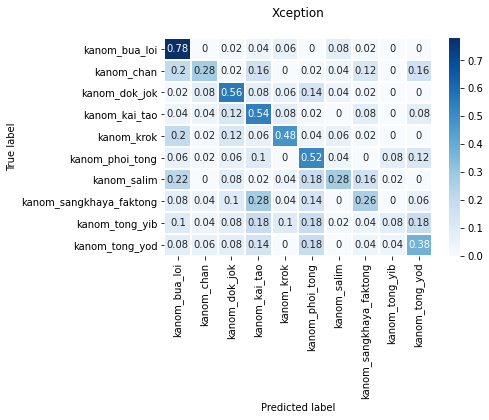

In [ ]:
cf_matrix = confusion_matrix(true_classes, predicted_classes, normalize='true')
sns.heatmap(cf_matrix, annot=True, cmap='Blues', linewidths=1,xticklabels=class_names,yticklabels=class_names)

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Xception\n')
plt.show()

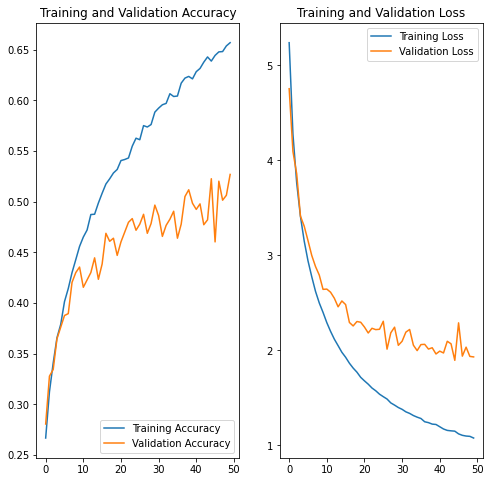

In [ ]:
# Visualize training results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(50)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()